In [12]:
# for MPI to work in the notebook I needed to add the following to ~/.local/share/jupyter/kernels/myenv/kernel.json :
# "env": {
#  "LD_LIBRARY_PATH": "/mnt/sw/nix/store/pa59vldasm7gxpr7dkijhk09q5qq63q1-openmpi-4.1.8/lib:${LD_LIBRARY_PATH}",
#  "PATH": "/mnt/sw/nix/store/pa59vldasm7gxpr7dkijhk09q5qq63q1-openmpi-4.1.8/bin:${PATH}"
#}
# the path was found with !echo $LD_LIBRARY_PATH

import argparse
import os
import time
import numpy as np
import h5py
from unyt import angstrom, Msun, yr, deg, kelvin
from astropy.cosmology import Planck15 as cosmo
import random
import math
from scipy.stats import qmc
from mpi4py import MPI
from matplotlib import pyplot as plt

# Synthesizer imports
from synthesizer import check_openmp
print('OpenMP enabled:', check_openmp())

from synthesizer.grid import Grid
from synthesizer.emission_models import (
    BlackHoleEmissionModel,
    GalaxyEmissionModel,
    StellarEmissionModel,
    AttenuatedEmission,
)

from synthesizer.emission_models.attenuation import ParametricLi08
from synthesizer.emission_models.dust.emission import Blackbody

from synthesizer.particle.galaxy import Galaxy as ParticleGalaxy
from synthesizer.particle.stars import Stars as ParticleStars
from synthesizer.particle import BlackHoles
from synthesizer.pipeline import Pipeline  # , combine_files_virtual

OpenMP enabled: True


In [2]:
sam_dir = '/mnt/ceph/users/lperez/AGNmodelingSCSAM/sam_newAGNcode_forestmgmt_fidSAM'
grid_dir = '/mnt/ceph/users/snewman/grids'
grid_name = 'qsosed.hdf5'
grid_sps_name = 'bpass-2.2.1-bin_bpl-0.1,1.0,300.0-1.3,2.35.hdf5'

# Define a single, desired output wavelength array (e.g., 10000 points from 10 A to 1,000,000 A)
desired_lams = np.logspace(0.1, 6, 100000) * angstrom

# Load grids
grid_agn = Grid(grid_dir=grid_dir, grid_name=grid_name, ignore_lines=True, new_lam=desired_lams)
grid_sps = Grid(grid_dir=grid_dir, grid_name=grid_sps_name, ignore_lines=True, new_lam=desired_lams)

/mnt/home/snewman/myenv/lib/python3.12/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


In [31]:
def load_single_lhc_sample(filepath, index):
    """
    Load one Latin Hypercube sample (single row) by index from a .txt file.
    The dust parameter names are inferred from the header line.
    """
    # Read header (first line)
    with open(filepath, 'r') as f:
        header_line = f.readline().strip()
        # Split header by whitespace or tabs
        param_names = header_line.split()

    # Load numeric data, skipping the header line
    data = np.loadtxt(filepath, skiprows=1)

    # Validate index
    if index < 0 or index >= len(data):
        raise IndexError(f"Index {index} is out of range (file has {len(data)} samples).")

    # Build dictionary of parameter: value
    sample = {param_names[i]: float(data[index, i]) for i in range(len(param_names))}

    print(f"✅ Loaded sample #{index} from {os.path.basename(filepath)}")
    for k, v in sample.items():
        print(f"  {k}: {v:.4f}")

    return sample


def get_single_galaxy(SFH, age_lst, Z_hist, bh_mass, bh_mdot, z, to_gal_prop_idx, **dust_params):
    """Create a particle-based galaxy using Synthesizer using the SC-SAM data
    loaded in get_galaxies. We also need the LHS dust parameters."""

    # Initial mass, age, metallicity arrays for stars
    p_imass, p_age, p_Z = [], [], []
    for age_ind in range(len(age_lst)):
        if (SFH[age_ind] == 0).all():
            continue
        p_imass.append(SFH[age_ind])
        p_age.append(age_lst[age_ind])
        p_Z.append(Z_hist[age_ind])
    p_imass = np.array(p_imass) * 1e9  # Msun
    p_age = np.array(p_age) * 1e9      # yr
    p_Z = np.array(p_Z)

    stars = ParticleStars(initial_masses=p_imass * Msun,
                          ages=p_age * yr,
                          metallicities=p_Z)

    black_holes = BlackHoles(
        masses=np.array([bh_mass]) * Msun,
        accretion_rates=np.array([bh_mdot]) * Msun / yr
    )

    # Pick a random cosine inclination between 0.1 and 0.98
    cosine_inc = random.uniform(0.1, 0.98)
    inc_deg = math.acos(cosine_inc) * (180 / math.pi)
    black_holes.inclination = inc_deg * deg

    gal = ParticleGalaxy(
        redshift=z,
        to_gal_prop_idx=to_gal_prop_idx,
        stars=stars,
        black_holes=black_holes
    )

    return gal


def get_galaxies(subvol="0_0_0", N=None, comm=None):
    """Load galaxies for a given subvolume (or all subvolumes),
    distributed across MPI ranks."""

    rank = comm.Get_rank() if comm else 0
    size = comm.Get_size() if comm else 1
    sv = subvol

    with h5py.File(f'{sam_dir}/volume.hdf5', 'r') as file:
        bh_mass_sub = file[f'{sv}/Galprop/GalpropMBH'][:] * 1e9
        bh_mdot_sub1 = file[f'{sv}/Galprop/GalpropMaccdot_bright'][:]
        bh_mdot_sub2 = file[f'{sv}/Galprop/GalpropMaccdot_radio'][:]
        bh_mdot_sub = bh_mdot_sub1

        sfh = file[f'{sv}/Histprop/HistpropSFH'][:]
        z_hist = file[f'{sv}/Histprop/HistpropZt'][:]
        to_gal_prop = file[f'{sv}/Linkprop/LinkproptoGalprop'][:]
        redshift = file[f'{sv}/Linkprop/LinkpropRedshift'][:]
        sfh_t_bins = file[f'{sv}/Header/SFH_tbins'][:]

        bh_mass = bh_mass_sub[to_gal_prop]
        bh_mdot = bh_mdot_sub[to_gal_prop]

    # Apply mask: keep only galaxies with bh_mdot > 0
    mask = bh_mdot > 0
    bh_mass = bh_mass[mask]
    bh_mdot = bh_mdot[mask]
    sfh = sfh[mask]
    z_hist = z_hist[mask]
    redshift = redshift[mask]
    to_gal_prop = to_gal_prop[mask]

    all_indices = np.arange(len(bh_mass))

    # Case 1: User requested a total of N galaxies
    if N == 1:
        if rank == 0:
            sampled_indices = [0]
        sampled_indices = comm.bcast(sampled_indices, root=0)
    else:
        sampled_indices = all_indices

    # Split work across MPI ranks evenly
    my_indices = np.array_split(sampled_indices, size)[rank]
    print(f"Rank {rank}/{size}: processing {len(my_indices)} galaxies (total {len(sampled_indices)})")

    galaxies = []
    for gal_idx in my_indices:

        galaxy = get_single_galaxy(
            SFH=sfh[gal_idx],
            age_lst=sfh_t_bins,
            Z_hist=z_hist[gal_idx],
            bh_mass=bh_mass[gal_idx],
            bh_mdot=bh_mdot[gal_idx],
            z=redshift[gal_idx],
            to_gal_prop_idx=to_gal_prop[gal_idx]
        )
        galaxies.append(galaxy)

    return galaxies


def emission_model(dust_param_values):
    """Define combined emission model using loaded grids."""
    stellar_incident = StellarEmissionModel(
        "stellar_incident", grid=grid_sps, extract="incident", fesc=1.0
    )
    agn_incident = BlackHoleEmissionModel(
        "agn_incident", grid=grid_agn, extract="incident", fesc=1.0
    )

    # Get LHC dust parameters from galaxy attributes, loaded from LHC file
    li08_curve = ParametricLi08(
        UV_slope=dust_param_values[0],
        OPT_NIR_slope=1.87,
        FUV_slope=dust_param_values[1],
        bump=dust_param_values[2],
        model='Custom'
    )

    stellar_attenuated = AttenuatedEmission(
        emitter="stellar",
        apply_to=stellar_incident,
        dust_curve=li08_curve,
        tau_v=0.5,
        label="stellar_attenuated",
    )

    agn_attenuated = AttenuatedEmission(
        emitter="blackhole",
        apply_to=agn_incident,
        dust_curve=li08_curve,
        tau_v=0.5,
        label="agn_attenuated",
    )

    combined_emission = GalaxyEmissionModel(
        "total", combine=(stellar_attenuated, agn_attenuated)
    )
    return combined_emission

Processing LHC sample index: 0
✅ Loaded sample #0 from samples_5.txt
  UV_slope: 10.5090
  FUV_slope: 3.7356
  bump: 0.0188
Rank 0/1: processing 1 galaxies (total 1)


/tmp/ipykernel_2364720/148667811.py:59: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to
`None`
  gal = ParticleGalaxy(
/mnt/home/snewman/myenv/lib/python3.12/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Processing LHC sample index: 1
✅ Loaded sample #1 from samples_5.txt
  UV_slope: 24.8585
  FUV_slope: 1.3937
  bump: 0.1056
Rank 0/1: processing 1 galaxies (total 1)
Processing LHC sample index: 2
✅ Loaded sample #2 from samples_5.txt
  UV_slope: 38.2815
  FUV_slope: 0.0608
  bump: 0.1814
Rank 0/1: processing 1 galaxies (total 1)
Processing LHC sample index: 3
✅ Loaded sample #3 from samples_5.txt
  UV_slope: 2.1806
  FUV_slope: 4.5946
  bump: 0.2281
Rank 0/1: processing 1 galaxies (total 1)
Processing LHC sample index: 4
✅ Loaded sample #4 from samples_5.txt
  UV_slope: 44.5939
  FUV_slope: -1.9294
  bump: 0.0578
Rank 0/1: processing 1 galaxies (total 1)


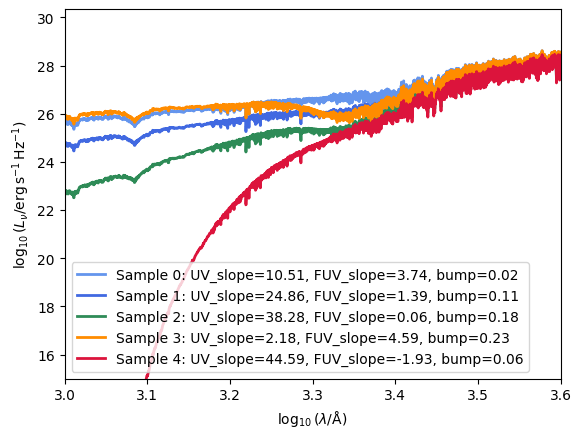

In [36]:
nthreads = 1
N = None
subvolume = "0_0_0"

lhc_file = "/mnt/home/snewman/ceph/lhc_samples/samples_5.txt"

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

sample_indices = np.arange(5)

colors = ['cornflowerblue',
        'royalblue',
        'seagreen',
        'darkorange',
        'crimson'
        ]

for sample_index in sample_indices:

    print(f"Processing LHC sample index: {sample_index}")

    sample = load_single_lhc_sample(lhc_file, sample_index)

    dust_param_names = list(sample.keys())
    dust_param_values = list(sample.values())


    galaxies = get_galaxies(subvol=subvolume, N=1, comm=comm)

    model = emission_model(dust_param_values)

    spectra = galaxies[0].get_spectra(model)

    lam = spectra.wavelength
    lnu = spectra.lnu

    # Format the dictionary into a nice string for the legend
    label = f"Sample {sample_index}: " + ", ".join(
        [f"{k}={v:.2f}" for k, v in sample.items()]
    )

    plt.plot(np.log10(lam), np.log10(lnu), lw=2, label=label, color=colors[sample_index])
    plt.xlim(left=3, right=3.6)
    plt.ylim(bottom=15)

    plt.xlabel(r"$\log_{10}(\lambda/\rm{\AA})$")
    plt.ylabel(r"$\log_{10}(L_\nu/\rm{erg\,s^{-1}\,Hz^{-1}})$")
    plt.legend()